**Expected inputs (generated by `src/pipeline.py`):**
- data/outputs/boundary_metadata.json
- data/processed/landuse.gpkg
- data/processed/pois.gpkg
- data/processed/poi_grid.gpkg
- data/processed/buildings.gpkg
- data/processed/building_grid.gpkg
- data/processed/street_edges.gpkg
- data/processed/street_nodes.gpkg
- data/processed/street_network.graphml
- data/outputs/landuse_summary.csv
- data/outputs/poi_summary.csv
- data/outputs/poi_grid_summary.csv
- data/outputs/building_summary.csv
- data/outputs/building_density.png

In [1]:
from pathlib import Path
import json
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import numpy as np

DATA = Path('..') / 'data'
OUTPUTS = DATA / 'outputs'
PROCESSED = DATA / 'processed'
RAW = DATA / 'raw'
OSM_ID = 'R5167559'  # Córdoba
PROJECTED_CRS = 32720

In [2]:
# Load boundary from OSM (fresh)
boundary = ox.geocode_to_gdf(OSM_ID, by_osmid=True).to_crs(4326)
boundary.shape, boundary.crs

((1, 17),
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

In [3]:
# Load metadata (if present)
meta_path = OUTPUTS / 'boundary_metadata.json'
if meta_path.exists():
    with meta_path.open() as f:
        meta = json.load(f)
    meta
else:
    print('boundary_metadata.json not found; run pipeline first')

In [4]:
# Load layers (skip if missing)
paths = {
    'landuse': PROCESSED / 'landuse.gpkg',
    'pois': PROCESSED / 'pois.gpkg',
    'grid': PROCESSED / 'poi_grid.gpkg',
    'buildings': PROCESSED / 'buildings.gpkg',
    'building_grid': PROCESSED / 'building_grid.gpkg',
    'street_edges': PROCESSED / 'street_edges.gpkg',
    'street_nodes': PROCESSED / 'street_nodes.gpkg',
    'landuse_summary': OUTPUTS / 'landuse_summary.csv',
    'poi_summary': OUTPUTS / 'poi_summary.csv',
    'poi_grid_summary': OUTPUTS / 'poi_grid_summary.csv',
    'building_summary': OUTPUTS / 'building_summary.csv',
}

landuse = gpd.read_file(paths['landuse']) if paths['landuse'].exists() else gpd.GeoDataFrame()
pois = gpd.read_file(paths['pois']) if paths['pois'].exists() else gpd.GeoDataFrame()
grid = gpd.read_file(paths['grid']) if paths['grid'].exists() else gpd.GeoDataFrame()
buildings = gpd.read_file(paths['buildings']) if paths['buildings'].exists() else gpd.GeoDataFrame()
building_grid = gpd.read_file(paths['building_grid']) if paths['building_grid'].exists() else gpd.GeoDataFrame()
street_edges = gpd.read_file(paths['street_edges']) if paths['street_edges'].exists() else gpd.GeoDataFrame()
street_nodes = gpd.read_file(paths['street_nodes']) if paths['street_nodes'].exists() else gpd.GeoDataFrame()

landuse_summary = pd.read_csv(paths['landuse_summary']) if paths['landuse_summary'].exists() else pd.DataFrame()
poi_summary = pd.read_csv(paths['poi_summary']) if paths['poi_summary'].exists() else pd.DataFrame()
poi_grid_summary = pd.read_csv(paths['poi_grid_summary']) if paths['poi_grid_summary'].exists() else pd.DataFrame()
building_summary = pd.read_csv(paths['building_summary']) if paths['building_summary'].exists() else pd.DataFrame()

print('landuse', landuse.shape)
print('pois', pois.shape)
print('grid', grid.shape)
print('buildings', buildings.shape)
print('building_grid', building_grid.shape)
print('street_edges', street_edges.shape)

landuse (2891, 110)
pois (332, 5)
grid (2400, 24)
buildings (16239, 14)
building_grid (2400, 28)
street_edges (115316, 20)


In [5]:
# Quick summaries
display(landuse_summary.head())
display(poi_summary.head())
display(poi_grid_summary.head())
display(building_summary.head())

category    area_km2
0  landuse:residential  193.885024
1     landuse:military   33.152303
2     landuse:farmland   30.720517
3   landuse:industrial   25.148737
4        natural:heath   23.723359

category  count  density_per_km2
0  amenity:pharmacy    160         0.277995
1    amenity:school    145         0.251933
2  amenity:hospital     22         0.038224
3      leisure:park      5         0.008687

cell_id  area_km2  count  density_per_km2
0        0  0.105460      0              0.0
1        1  0.109353      0              0.0
2        2  0.112844      0              0.0
3        3  0.116334      0              0.0
4        4  0.119824      0              0.0

cell_id  area_km2  building_count  building_area_km2  building_density  \
0        0  0.105460               0                0.0               0.0   
1        1  0.109353               0                0.0               0.0   
2        2  0.112844               0                0.0               0.0   
3        3  0.116334               0                0.0               0.0   
4        4  0.119824               0                0.0               0.0   

   footprint_coverage  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

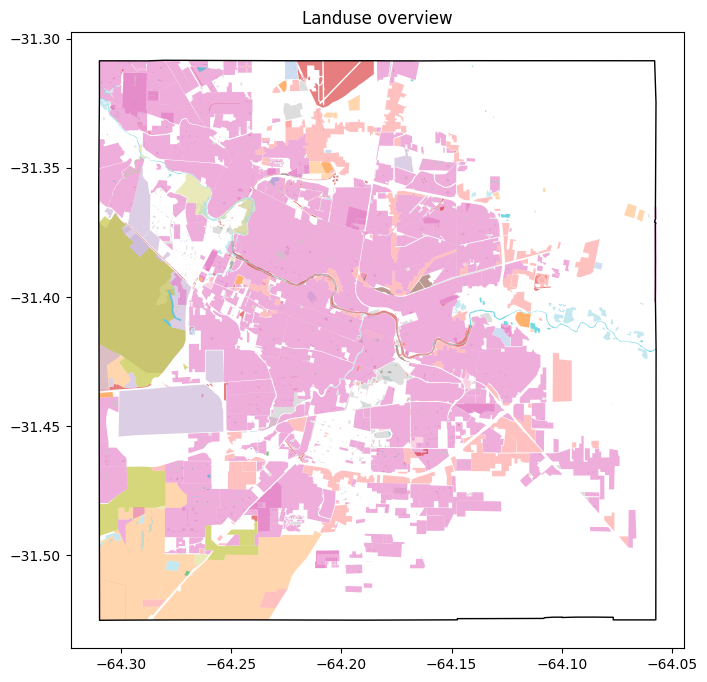

In [6]:
# Plot landuse
if not landuse.empty:
    fig, ax = plt.subplots(figsize=(8, 8))
    landuse.to_crs(4326).plot(column='category', ax=ax, legend=False, alpha=0.6, cmap='tab20')
    boundary.boundary.plot(ax=ax, color='black', linewidth=1)
    plt.title('Landuse overview')
else:
    print('Landuse layer not found; run pipeline first')

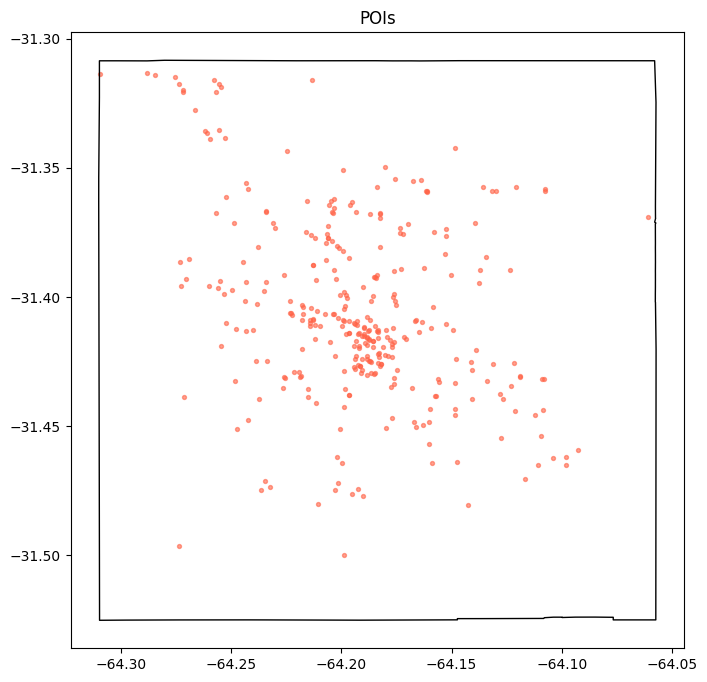

In [7]:
# Plot POIs
if not pois.empty:
    fig, ax = plt.subplots(figsize=(8, 8))
    pois.to_crs(4326).plot(ax=ax, color='tomato', markersize=8, alpha=0.6)
    boundary.boundary.plot(ax=ax, color='black', linewidth=1)
    plt.title('POIs')
else:
    print('POIs layer not found; run pipeline first')

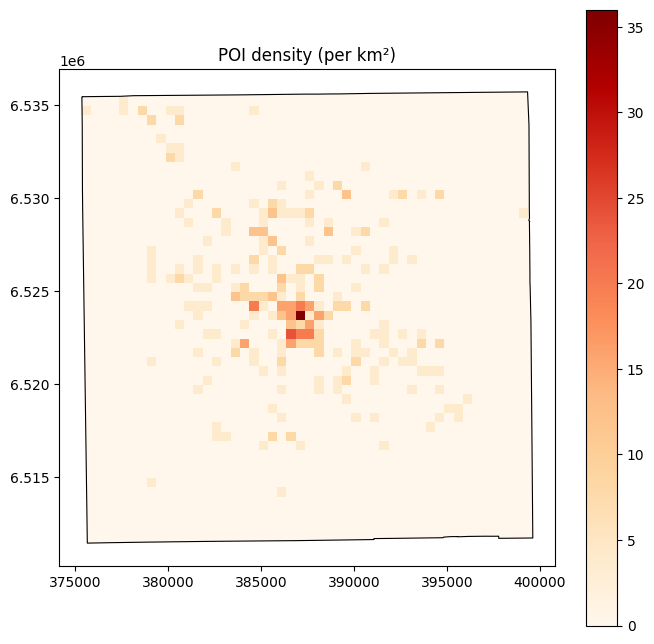

In [8]:
# Plot grid density
if not grid.empty:
    fig, ax = plt.subplots(figsize=(8, 8))
    grid.plot(column='density_per_km2', cmap='OrRd', legend=True, ax=ax, edgecolor='none')
    boundary.to_crs(grid.crs).boundary.plot(ax=ax, color='black', linewidth=0.8)
    plt.title('POI density (per km²)')
else:
    print('POI grid layer not found; run pipeline first')

Fetching street network (this may take a moment)...
Graph loaded: 37031 nodes, 115316 edges
Edges CRS: epsg:4326, Grid CRS: EPSG:32720
Plot complete - you should see streets (gray), density grid (yellow-red), and boundary (black)


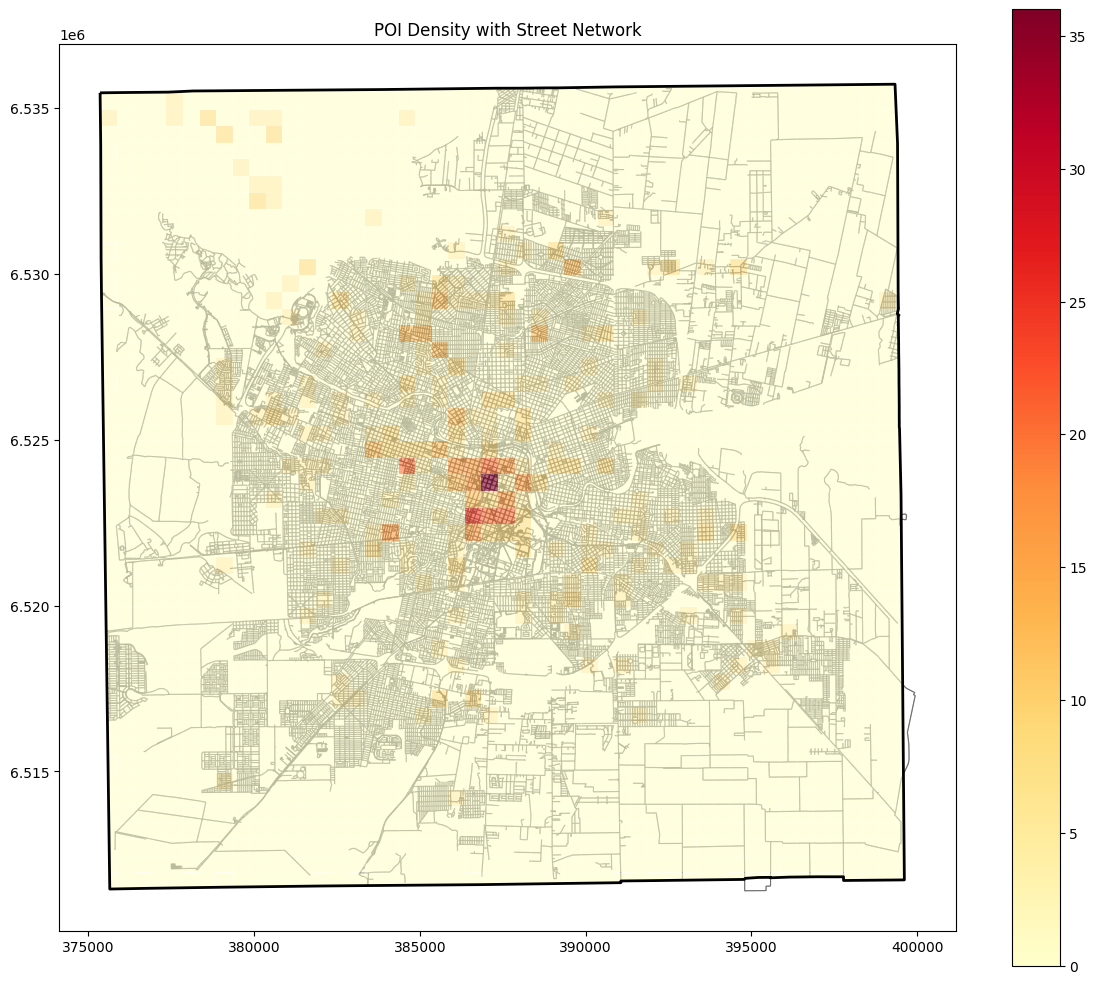

In [9]:
# Fetch street network and plot grid density with streets
if not grid.empty:
    print('Fetching street network (this may take a moment)...')
    poly = boundary.geometry.values[0]
    G = ox.graph_from_polygon(poly, network_type='walk')
    print(f'Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges')
    
    # Convert graph to GeoDataFrame edges
    edges = ox.graph_to_gdfs(G, nodes=False)
    print(f'Edges CRS: {edges.crs}, Grid CRS: {grid.crs}')
    
    # Ensure both are in the same CRS (use grid CRS)
    edges_proj = edges.to_crs(grid.crs)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # 1. Street network background (darker, visible)
    edges_proj.plot(ax=ax, color='#555555', linewidth=0.8, zorder=1, alpha=0.6)
    
    # 2. Grid density overlay (semi-transparent)
    grid.plot(column='density_per_km2', cmap='YlOrRd', legend=True, ax=ax, 
              edgecolor='white', linewidth=0.1, alpha=0.6, zorder=2)
    
    # 3. Boundary outline (on top)
    boundary.to_crs(grid.crs).boundary.plot(ax=ax, color='black', linewidth=2, zorder=3)
    
    plt.title('POI Density with Street Network')
    plt.tight_layout()
    print('Plot complete - you should see streets (gray), density grid (yellow-red), and boundary (black)')
else:
    print('Grid layer not found; run pipeline first')

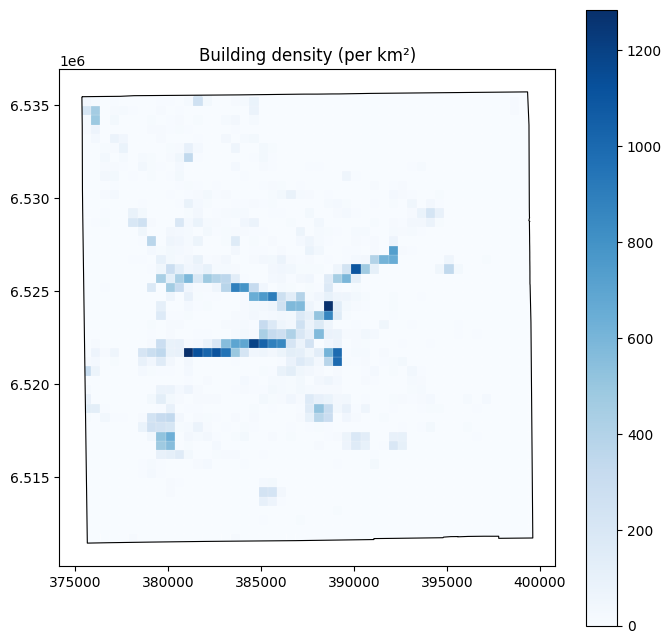

In [10]:
# Plot building density
if not building_grid.empty:
    fig, ax = plt.subplots(figsize=(8, 8))
    building_grid.plot(column='building_density', cmap='Blues', legend=True, ax=ax,
                       edgecolor='white', linewidth=0.1)
    boundary.to_crs(building_grid.crs).boundary.plot(ax=ax, color='black', linewidth=0.8)
    plt.title('Building density (per km²)')
else:
    print('Building grid layer not found; run pipeline first')

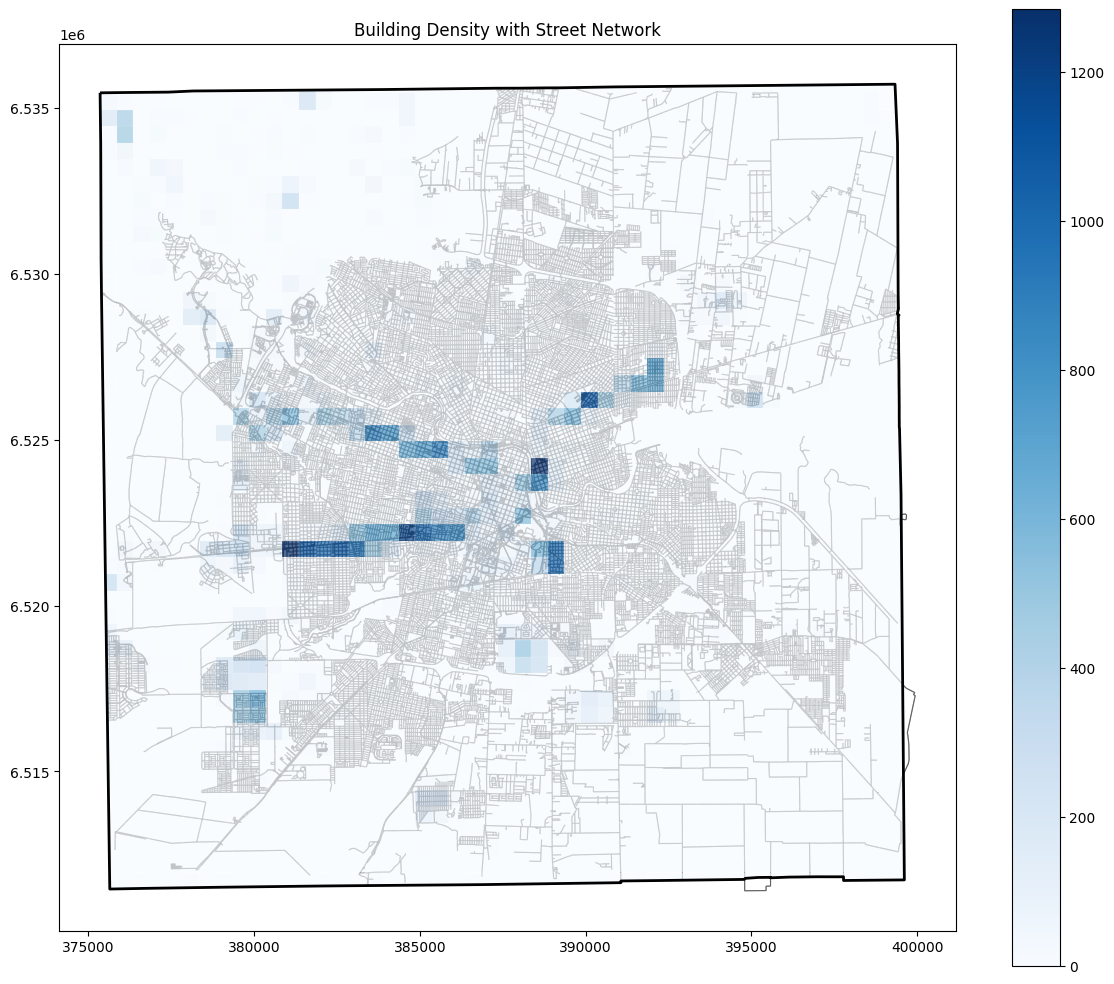

In [11]:
# Plot building density with street network overlay
if not building_grid.empty and not street_edges.empty:
    # Align CRS
    edges_proj = street_edges.to_crs(building_grid.crs)
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Streets background
    edges_proj.plot(ax=ax, color='#444444', linewidth=0.8, alpha=0.6, zorder=1)
    
    # Building density grid
    building_grid.plot(column='building_density', cmap='Blues', legend=True, ax=ax,
                       edgecolor='white', linewidth=0.1, alpha=0.7, zorder=2)
    
    # Boundary outline
    boundary.to_crs(building_grid.crs).boundary.plot(ax=ax, color='black', linewidth=2, zorder=3)
    
    plt.title('Building Density with Street Network')
    plt.tight_layout()
else:
    print('Building grid or street edges missing; run pipeline first')

### Lets inspect this

Top 5 densest cells (buildings per km²):


/tmp/ipykernel_28976/571479363.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top5['centroid_lat'] = top5_wgs.centroid.y
/tmp/ipykernel_28976/571479363.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top5['centroid_lon'] = top5_wgs.centroid.x


building_density  building_count  centroid_lat  centroid_lon  \
559             1284.0             321    -31.433244    -64.251007   
1299            1276.0             319    -31.411438    -64.171823   
903             1192.0             298    -31.429088    -64.214128   
608             1124.0             281    -31.433295    -64.245747   
706             1112.0             278    -31.433397    -64.235227   

                                                  gmaps  
559   https://www.google.com/maps?q=-31.433244,-64.2...  
1299  https://www.google.com/maps?q=-31.411438,-64.1...  
903   https://www.google.com/maps?q=-31.429088,-64.2...  
608   https://www.google.com/maps?q=-31.433295,-64.2...  
706   https://www.google.com/maps?q=-31.433397,-64.2...

                                                  gmaps
559   https://www.google.com/maps?q=-31.433244,-64.2...
1299  https://www.google.com/maps?q=-31.411438,-64.1...
903   https://www.google.com/maps?q=-31.429088,-64.2...
608   https://www.google.com/maps?q=-31.433295,-64.2...
706   https://www.google.com/maps?q=-31.433397,-64.2...

Most dense cell: 559
Building density: 1284.0 buildings/km²
Building count: 321
Footprint coverage: 18.40%
Cell area: 0.250 km²
Centroid (lat, lon): -31.433244, -64.251007
Google Maps link: https://www.google.com/maps?q=-31.433244,-64.251007
Bounds (minx, miny, maxx, maxy): (-64.253667, -31.435525, -64.248347, -31.430963)

321 buildings in this top cell:
Columns: ['element', 'id', 'building', 'name', 'building_levels', 'building_material', 'addr_housenumber', 'addr_street', 'addr_city', 'addr_postcode', 'addr_suburb', 'addr_province', 'addr_country', 'geometry']

Sample buildings:


building                                               name
2496      roof                                               None
5244     house                                               None
5245  hospital  Hospital de Pronta Atención Madre Teresa de Ca...
5246     house                                               None
5247     house                                               None
5248     house                                               None
5249     house                                               None
5250     house                                               None
5251     house                                               None
5252     house                                               None

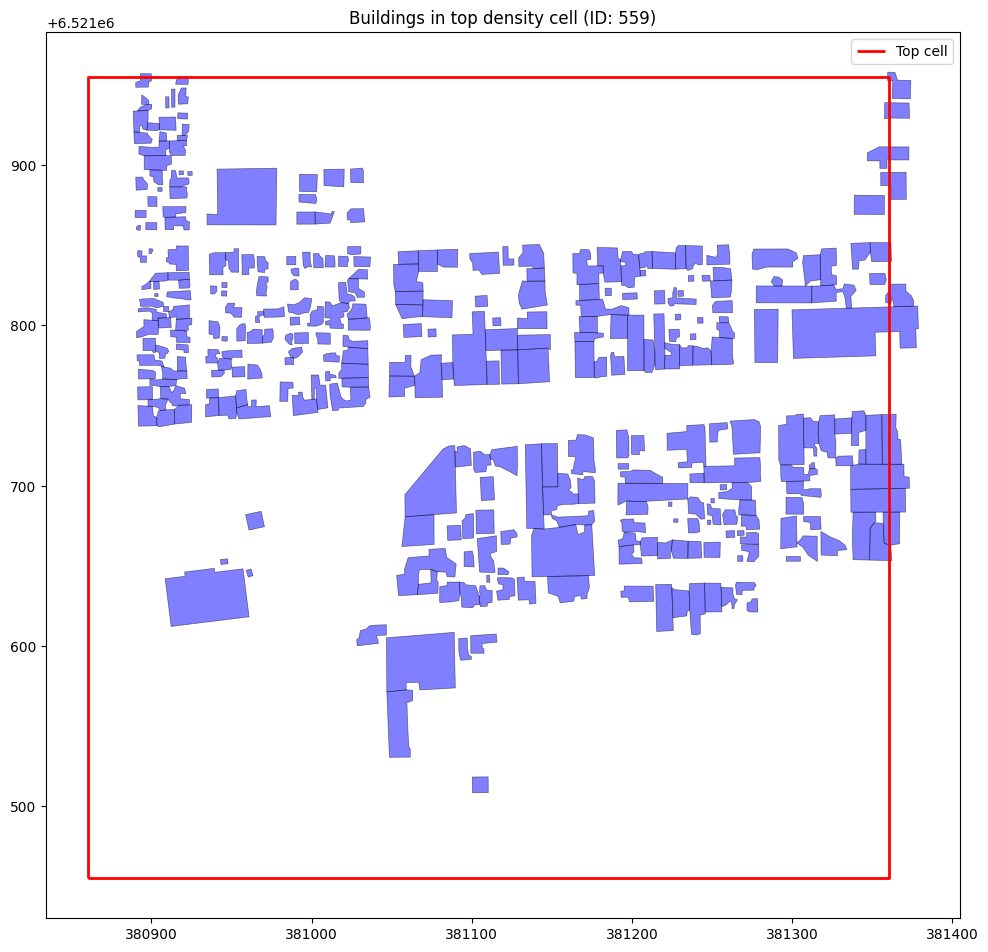

In [12]:
# Inspect top 5 densest building grid cells (with Google Maps links) and drill into the top cell
if not building_grid.empty and not buildings.empty:
    # Top 5 by building density
    top5 = building_grid.sort_values('building_density', ascending=False).head(5).copy()
    top5_wgs = top5.to_crs(4326)
    top5['centroid_lat'] = top5_wgs.centroid.y
    top5['centroid_lon'] = top5_wgs.centroid.x
    top5['gmaps'] = top5.apply(lambda r: f"https://www.google.com/maps?q={r['centroid_lat']:.6f},{r['centroid_lon']:.6f}", axis=1)
    
    print("Top 5 densest cells (buildings per km²):")
    display(top5[['building_density', 'building_count', 'centroid_lat', 'centroid_lon', 'gmaps']])
    print(top5[[ 'gmaps']])
    
    # Drill into the top cell
    max_cell = top5.iloc[0]
    max_geom_proj = max_cell.geometry
    max_geom_wgs = top5_wgs.iloc[0].geometry
    bounds = max_geom_wgs.bounds  # (minx, miny, maxx, maxy)
    
    print(f"\nMost dense cell: {max_cell['cell_id']}")
    print(f"Building density: {max_cell['building_density']:.1f} buildings/km²")
    print(f"Building count: {max_cell['building_count']}")
    print(f"Footprint coverage: {max_cell['footprint_coverage']:.2f}%")
    print(f"Cell area: {max_cell['area_km2']:.3f} km²")
    print(f"Centroid (lat, lon): {max_cell['centroid_lat']:.6f}, {max_cell['centroid_lon']:.6f}")
    print(f"Google Maps link: {max_cell['gmaps']}")
    print("Bounds (minx, miny, maxx, maxy):" , tuple(round(v, 6) for v in bounds))
    
    # Get buildings in this cell
    buildings_proj = buildings.to_crs(building_grid.crs)
    buildings_in_cell = buildings_proj[buildings_proj.intersects(max_geom_proj)].copy()
    
    print(f"\n{len(buildings_in_cell)} buildings in this top cell:")
    print(f"Columns: {list(buildings_in_cell.columns)}")
    print("\nSample buildings:")
    display(buildings_in_cell[['building', 'name']].head(10))
    
    # Plot the cell with its buildings
    fig, ax = plt.subplots(figsize=(10, 10))
    building_grid[building_grid['cell_id'] == max_cell['cell_id']].boundary.plot(ax=ax, color='red', linewidth=2, label='Top cell')
    buildings_in_cell.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black', linewidth=0.5)
    plt.title(f"Buildings in top density cell (ID: {max_cell['cell_id']})")
    plt.legend()
    plt.tight_layout()
else:
    print('Building grid or buildings layer missing')

Merged cells: 2400
       poi_density  building_density
count  2400.000000       2400.000000
mean      0.553364         29.386667
std       2.185411        114.054858
min       0.000000          0.000000
25%       0.000000          0.000000
50%       0.000000          0.000000
75%       0.000000          8.000000
max      36.000000       1284.000000
Correlation (Pearson): 0.235


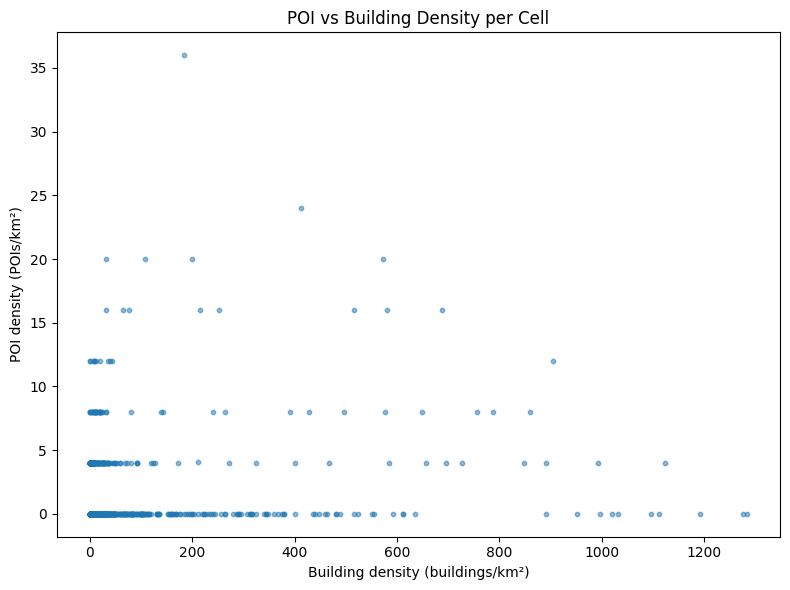

In [13]:
# Compare POI vs Building density (per cell)
if not grid.empty and not building_grid.empty:
    # Align by cell_id
    g = grid[['cell_id', 'density_per_km2']].rename(columns={'density_per_km2': 'poi_density'})
    b = building_grid[['cell_id', 'building_density', 'footprint_coverage']]
    merged = g.merge(b, on='cell_id', how='inner')
    print(f"Merged cells: {len(merged)}")
    print(merged[['poi_density', 'building_density']].describe())
    
    # Scatter plot
    fig, ax = plt.subplots(figsize=(8, 6))
    merged.plot.scatter(x='building_density', y='poi_density', alpha=0.5, s=10, ax=ax)
    plt.xlabel('Building density (buildings/km²)')
    plt.ylabel('POI density (POIs/km²)')
    plt.title('POI vs Building Density per Cell')
    plt.tight_layout()
    
    # Correlation
    corr = merged[['poi_density', 'building_density']].corr().iloc[0,1]
    print(f"Correlation (Pearson): {corr:.3f}")
else:
    print('Missing grid or building_grid; run pipeline first')

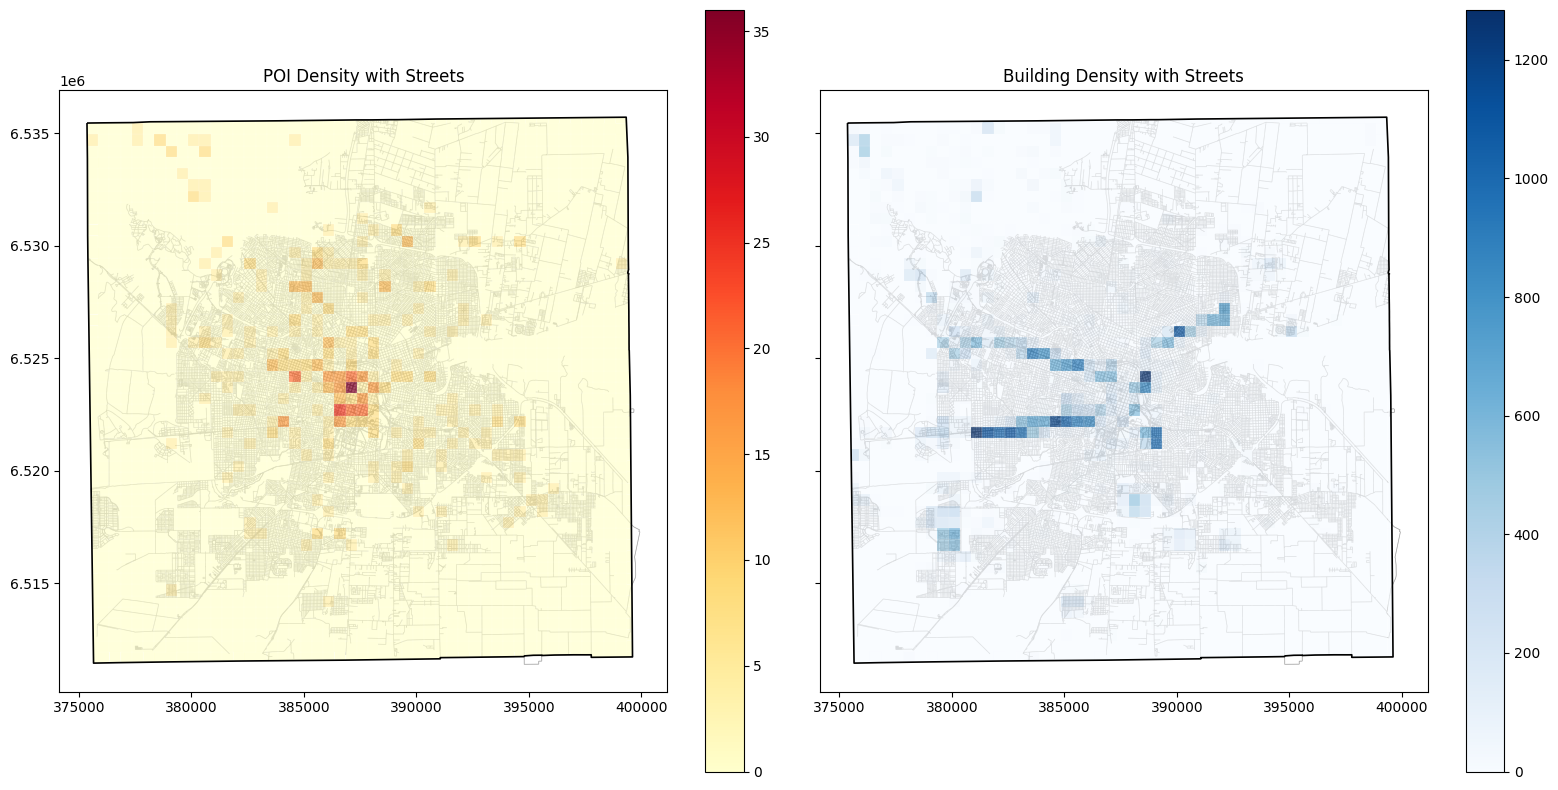

In [14]:
# Side-by-side: POI density vs Building density with street network
if not grid.empty and not building_grid.empty and not street_edges.empty:
    edges_proj = street_edges.to_crs(grid.crs)
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
    
    # POI density
    edges_proj.plot(ax=axes[0], color='#888888', linewidth=0.5, alpha=0.5, zorder=1)
    grid.plot(column='density_per_km2', cmap='YlOrRd', ax=axes[0], edgecolor='white', linewidth=0.1, alpha=0.7, zorder=2, legend=True)
    boundary.to_crs(grid.crs).boundary.plot(ax=axes[0], color='black', linewidth=1.2, zorder=3)
    axes[0].set_title('POI Density with Streets')
    
    # Building density
    edges_proj.plot(ax=axes[1], color='#888888', linewidth=0.5, alpha=0.5, zorder=1)
    building_grid.to_crs(grid.crs).plot(column='building_density', cmap='Blues', ax=axes[1], edgecolor='white', linewidth=0.1, alpha=0.7, zorder=2, legend=True)
    boundary.to_crs(grid.crs).boundary.plot(ax=axes[1], color='black', linewidth=1.2, zorder=3)
    axes[1].set_title('Building Density with Streets')
    
    plt.tight_layout()
else:
    print('Missing grid/building_grid/street_edges; run pipeline first')

Counts summary:
         res_count  nonres_count
count  2400.000000   2400.000000
mean      4.571250      2.775417
std      23.246561      9.580748
min       0.000000      0.000000
25%       0.000000      0.000000
50%       0.000000      0.000000
75%       0.000000      2.000000
max     289.000000    141.000000


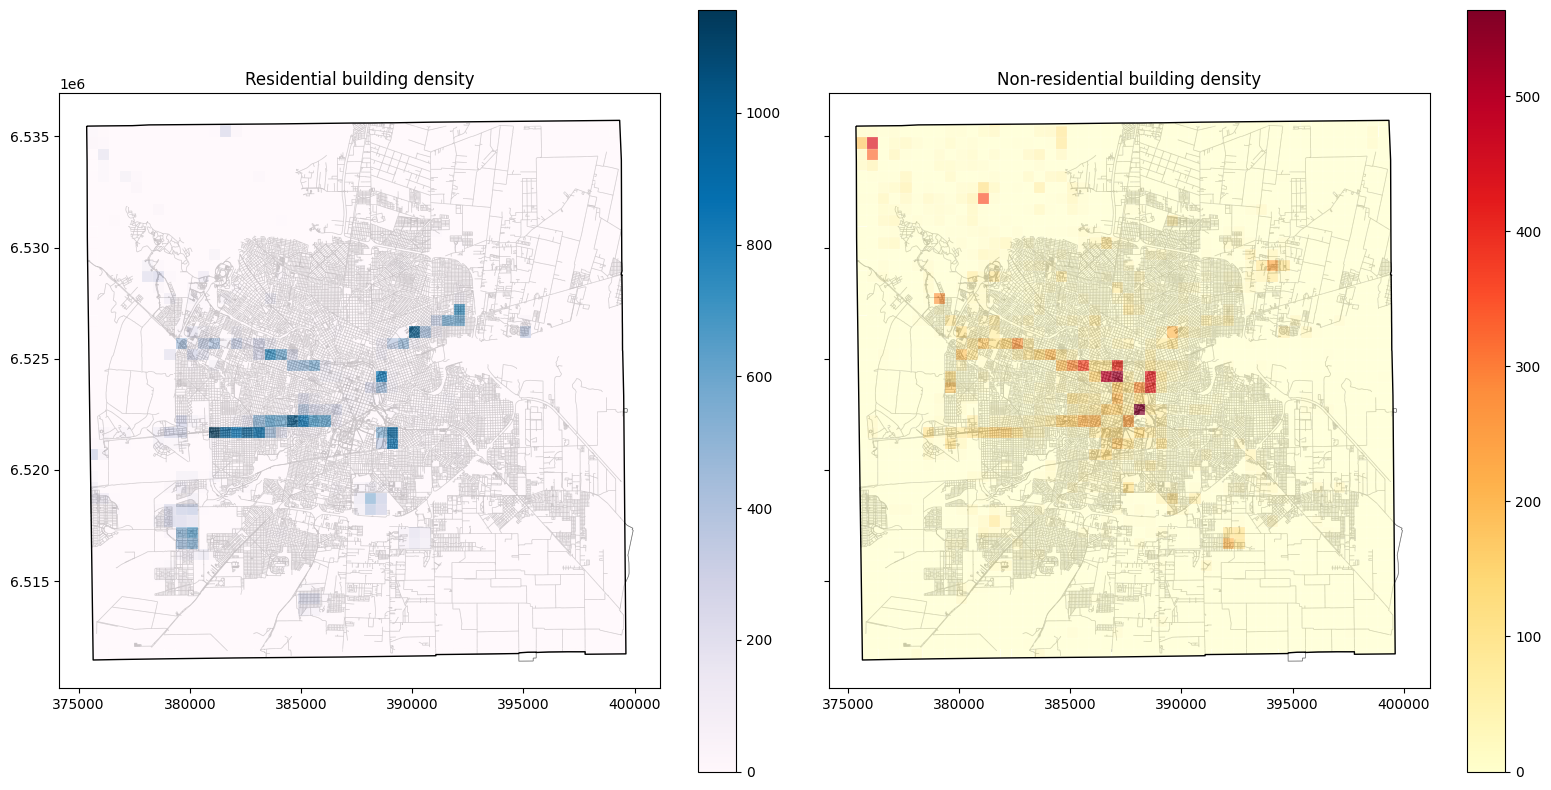

In [15]:
# Side-by-side: Residential vs Non-residential building density with streets
if not building_grid.empty and not buildings.empty and not street_edges.empty:
    # Define residential building tags
    residential_tags = {
        'house','apartments','residential','terrace','detached','semidetached_house','static_caravan','bungalow'
    }
    
    buildings_proj = buildings.to_crs(building_grid.crs).copy()
    buildings_proj['building_val'] = buildings_proj['building'].astype(str).str.lower()
    buildings_proj['is_res'] = buildings_proj['building_val'].isin(residential_tags)
    
    base = building_grid[['cell_id','geometry','area_km2']].copy()
    if 'cell_area_km2_full' in building_grid.columns:
        base['denom_km2'] = building_grid['cell_area_km2_full']
    else:
        base['denom_km2'] = base['area_km2']
    base['denom_km2'] = base['denom_km2'].replace(0, np.nan)
    
    joined = gpd.sjoin(buildings_proj, base[['cell_id','geometry']], how='inner', predicate='intersects')
    if joined.empty:
        print('No buildings joined to grid; check data')
    else:
        counts = joined.groupby(['cell_id','is_res']).size().unstack(fill_value=0)
        counts = counts.rename(columns={True:'res_count', False:'nonres_count'})
        base = base.merge(counts, on='cell_id', how='left')
        base[['res_count','nonres_count']] = base[['res_count','nonres_count']].fillna(0)
        base['res_density'] = base['res_count'] / base['denom_km2']
        base['nonres_density'] = base['nonres_count'] / base['denom_km2']
        
        print('Counts summary:')
        print(base[['res_count','nonres_count']].describe())
        
        edges_proj = street_edges.to_crs(base.crs)
        fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
        
        edges_proj.plot(ax=axes[0], color='#444444', linewidth=0.5, alpha=0.5, zorder=1)
        base.plot(column='res_density', cmap='PuBu', ax=axes[0], edgecolor='white', linewidth=0.1, alpha=0.7, zorder=2, legend=True)
        boundary.to_crs(base.crs).boundary.plot(ax=axes[0], color='black', linewidth=1.0, zorder=3)
        axes[0].set_title('Residential building density')
        
        edges_proj.plot(ax=axes[1], color='#444444', linewidth=0.5, alpha=0.5, zorder=1)
        base.plot(column='nonres_density', cmap='YlOrRd', ax=axes[1], edgecolor='white', linewidth=0.1, alpha=0.7, zorder=2, legend=True)
        boundary.to_crs(base.crs).boundary.plot(ax=axes[1], color='black', linewidth=1.0, zorder=3)
        axes[1].set_title('Non-residential building density')
        
        plt.tight_layout()
else:
    print('Missing building_grid/buildings/street_edges; run pipeline first')

In [20]:
# Load neighborhoods from KML
neighborhoods_path = RAW / 'neighborhoods.kml'
if neighborhoods_path.exists():
    import xml.etree.ElementTree as ET
    import re
    
    # Load geometries with GeoPandas
    neighborhoods = gpd.read_file(neighborhoods_path, driver='KML')
    neighborhoods = neighborhoods.to_crs(PROJECTED_CRS)
    
    # Parse KML XML to extract neighborhood names from Description
    tree = ET.parse(neighborhoods_path)
    root = tree.getroot()
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}
    
    names = []
    for placemark in root.findall('.//kml:Placemark', ns):
        desc = placemark.find('kml:description', ns)
        if desc is not None and desc.text:
            # Extract "Nombre" from HTML table
            match = re.search(r'<td>Nombre</td>\s*<td>([^<]+)</td>', desc.text, re.IGNORECASE)
            if match:
                names.append(match.group(1).strip())
            else:
                names.append(None)
        else:
            names.append(None)
    
    # Add parsed names to GeoDataFrame
    if len(names) == len(neighborhoods):
        neighborhoods['neighborhood_name'] = names
        # Fallback to index for any that failed
        neighborhoods.loc[neighborhoods['neighborhood_name'].isna(), 'neighborhood_name'] = 'Unknown ' + neighborhoods.index.astype(str)
        print(f'Loaded {len(neighborhoods)} neighborhoods')
        print(f'Parsed {sum([n is not None for n in names])} neighborhood names from KML Description HTML')
        print(f'Sample names: {neighborhoods["neighborhood_name"].head(10).tolist()}')
    else:
        print(f'Warning: Mismatch between geometries ({len(neighborhoods)}) and names ({len(names)})')
        neighborhoods['neighborhood_name'] = 'Unknown ' + neighborhoods.index.astype(str)
else:
    neighborhoods = gpd.GeoDataFrame()
    print(f'KML file not found at {neighborhoods_path}')
    print('Download from city website and save as: data/raw/neighborhoods.kml')

Loaded 485 neighborhoods
Parsed 485 neighborhood names from KML Description HTML
Sample names: ['CENTRO AMERICA', 'VILLA GRAN PARQUE', 'MERCANTIL', 'EL CERRITO', 'LOURDES', 'GUIÑAZU SUD', 'LICEO GENERAL PAZ', 'REMEDIOS DE ESCALADA', 'SAN JOSE', 'QUINTAS DE ARGUELLO']


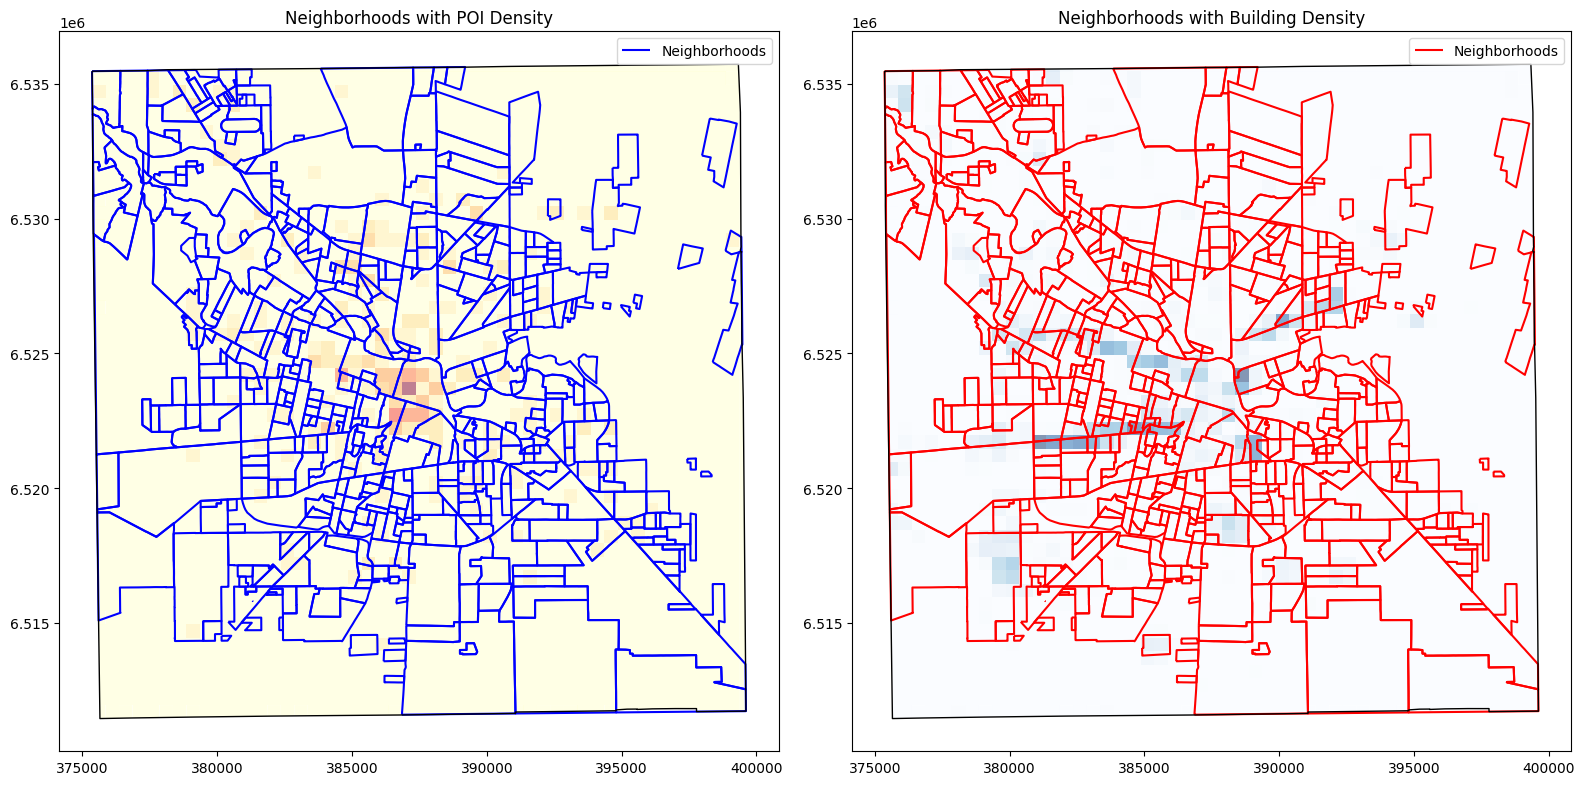

In [21]:
# Visualize neighborhoods with POI and building density overlay
if not neighborhoods.empty and not grid.empty and not building_grid.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Left: Neighborhoods + POI density
    grid.plot(column='density_per_km2', cmap='YlOrRd', ax=axes[0], edgecolor='none', alpha=0.5, zorder=1)
    neighborhoods.boundary.plot(ax=axes[0], color='blue', linewidth=1.5, zorder=2, label='Neighborhoods')
    boundary.to_crs(grid.crs).boundary.plot(ax=axes[0], color='black', linewidth=1, zorder=3)
    axes[0].set_title('Neighborhoods with POI Density')
    axes[0].legend()
    
    # Right: Neighborhoods + Building density
    building_grid.to_crs(grid.crs).plot(column='building_density', cmap='Blues', ax=axes[1], edgecolor='none', alpha=0.5, zorder=1)
    neighborhoods.boundary.plot(ax=axes[1], color='red', linewidth=1.5, zorder=2, label='Neighborhoods')
    boundary.to_crs(grid.crs).boundary.plot(ax=axes[1], color='black', linewidth=1, zorder=3)
    axes[1].set_title('Neighborhoods with Building Density')
    axes[1].legend()
    
    plt.tight_layout()
else:
    print('Missing neighborhoods, grid, or building_grid')


Top 10 by total building count:


neighborhood_name  area_km2  poi_count  building_count  poi_density  \
445         MANANTIALES II  7.207415        1.0           944.0     0.138746   
191                ALBERDI  2.467478       21.0           749.0     8.510713   
301           ALTO ALBERDI  3.880969       12.0           690.0     3.092011   
190                 CENTRO  3.124022       36.0           606.0    11.523606   
345            GENERAL PAZ  1.133050        7.0           559.0     6.178014   
385                 JOCKEY  1.574514        0.0           434.0     0.000000   
307     GENERAL PUEYRREDON  2.921127        3.0           405.0     1.027001   
34              CRISOL SUD  0.516535        1.0           403.0     1.935977   
110           AMEGHINO SUD  0.532510        0.0           370.0     0.000000   
397  RESIDENCIAL SAN ROQUE  1.579554        1.0           362.0     0.633090   

     building_density  
445        130.976219  
191        303.548779  
301        177.790627  
190        193.980698  
345        493.358532  
385        275.640677  
307        138.645117  
34         780.198652  
110        694.822335  
397        229.178645

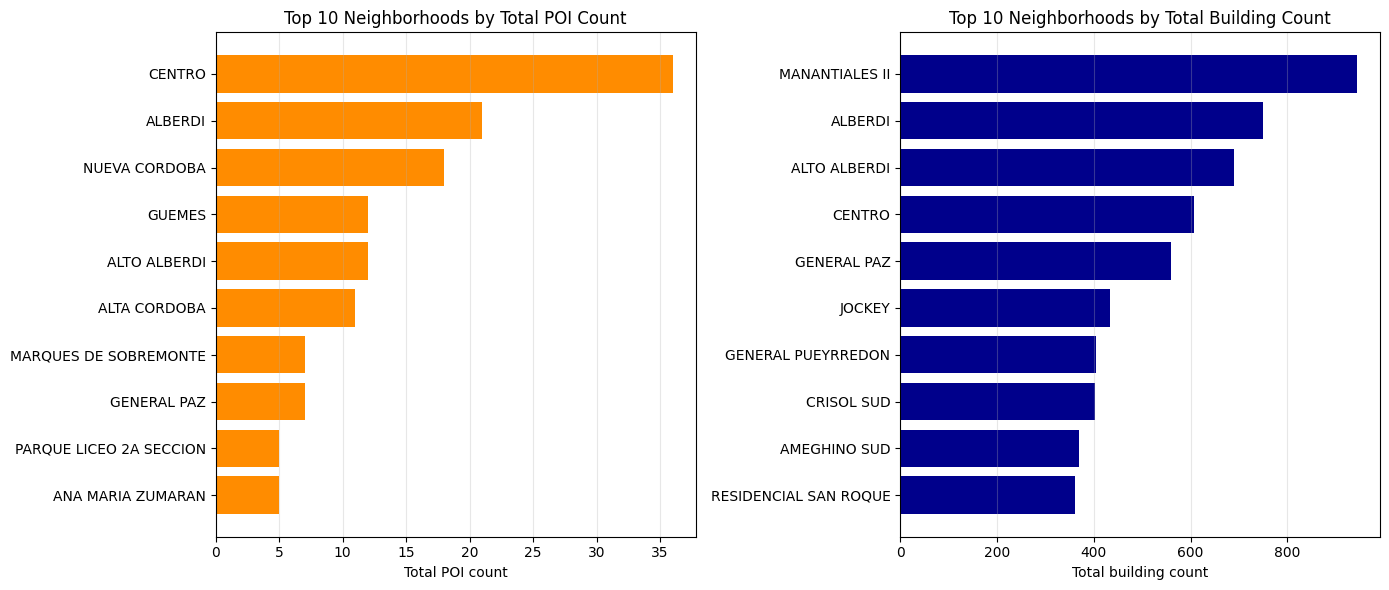

In [23]:
# Top 10 neighborhoods by total POI and Building counts
if not neighborhoods.empty and 'neighborhood_name' in neighborhoods.columns:
    # Use the same nh_stats from previous cell
    if 'nh_stats' in locals():
        # Top 10 by absolute counts
        top_poi_count = nh_stats.nlargest(10, 'poi_count').sort_values('poi_count', ascending=True)
        top_bld_count = nh_stats.nlargest(10, 'building_count').sort_values('building_count', ascending=True)
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # POI count bar plot
        axes[0].barh(top_poi_count[name_col], top_poi_count['poi_count'], color='darkorange')
        axes[0].set_xlabel('Total POI count')
        axes[0].set_title('Top 10 Neighborhoods by Total POI Count')
        axes[0].grid(axis='x', alpha=0.3)
        
        # Building count bar plot
        axes[1].barh(top_bld_count[name_col], top_bld_count['building_count'], color='darkblue')
        axes[1].set_xlabel('Total building count')
        axes[1].set_title('Top 10 Neighborhoods by Total Building Count')
        axes[1].grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        
        print('\nTop 10 by total building count:')
        display(nh_stats.sort_values('building_count', ascending=False)[[name_col,'area_km2','poi_count','building_count','poi_density','building_density']].head(10))
    else:
        print('Run the previous neighborhood analysis cell first')
else:
    print('Neighborhoods not loaded or missing neighborhood_name column')

Unique neighborhoods: 452
Sample labels: ['CENTRO AMERICA', 'VILLA GRAN PARQUE', 'MERCANTIL', 'EL CERRITO', 'LOURDES', 'GUIÑAZU SUD', 'LICEO GENERAL PAZ', 'REMEDIOS DE ESCALADA', 'SAN JOSE', 'QUINTAS DE ARGUELLO']
POIs matched to 140 neighborhoods
Buildings matched to 329 neighborhoods

Top 10 by building density:


neighborhood_name  area_km2  poi_count  building_count  poi_density  \
221             MAURIZI  0.111831        0.0           169.0     0.000000   
113   VILLA REVOL ANEXO  0.189179        0.0           256.0     0.000000   
476         EL TROPEZON  0.124346        0.0           110.0     0.000000   
220    BAJADA SAN ROQUE  0.052737        0.0            46.0     0.000000   
109             A.T. E.  0.177987        0.0           141.0     0.000000   
34           CRISOL SUD  0.516535        1.0           403.0     1.935977   
223    CAROLA LORENZINI  0.073561        0.0            55.0     0.000000   
54   PARQUE MONTECRISTO  0.217843        1.0           154.0     4.590468   
110        AMEGHINO SUD  0.532510        0.0           370.0     0.000000   
105        LOS NARANJOS  0.509524        3.0           309.0     5.887844   

     building_density  
221       1511.204076  
113       1353.212172  
476        884.628678  
220        872.251640  
109        792.190890  
34         780.198652  
223        747.677481  
54         706.932081  
110        694.822335  
105        606.447976

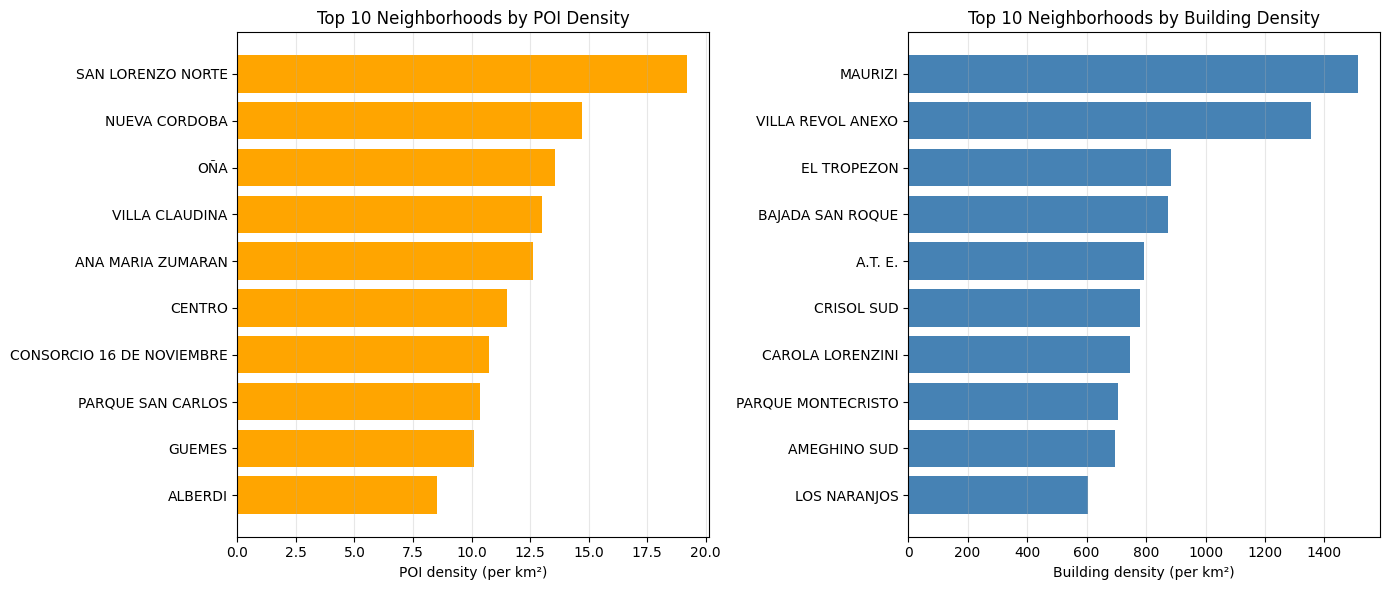

In [22]:
# Top 10 neighborhoods by POI and Building density
if not neighborhoods.empty and not grid.empty and not building_grid.empty:
    nh = neighborhoods.copy()
    
    # Use neighborhood_name if available (parsed from KML), otherwise fall back
    if 'neighborhood_name' not in nh.columns:
        print('Warning: neighborhood_name not found; using index')
        nh['neighborhood_name'] = 'Neighborhood ' + nh.index.astype(str)
    
    nh['nh_id'] = nh.index.astype(str)
    name_col = 'neighborhood_name'
    
    print(f'Unique neighborhoods: {nh[name_col].nunique()}')
    print(f'Sample labels: {nh[name_col].head(10).tolist()}')
    
    # POI counts per neighborhood (using nh_id for join)
    pois_proj = pois.to_crs(nh.crs) if not pois.empty else gpd.GeoDataFrame()
    if not pois_proj.empty:
        poi_joined = gpd.sjoin(pois_proj, nh[['nh_id',name_col,'geometry']], how='inner', predicate='within')
        poi_counts = poi_joined.groupby('nh_id').size().reset_index(name='poi_count')
        print(f'POIs matched to {len(poi_counts)} neighborhoods')
    else:
        poi_counts = pd.DataFrame(columns=['nh_id','poi_count'])
    
    # Building counts per neighborhood (using nh_id for join)
    buildings_proj = buildings.to_crs(nh.crs) if not buildings.empty else gpd.GeoDataFrame()
    if not buildings_proj.empty:
        bld_joined = gpd.sjoin(buildings_proj, nh[['nh_id',name_col,'geometry']], how='inner', predicate='intersects')
        bld_counts = bld_joined.groupby('nh_id').size().reset_index(name='building_count')
        print(f'Buildings matched to {len(bld_counts)} neighborhoods')
    else:
        bld_counts = pd.DataFrame(columns=['nh_id','building_count'])
    
    # Merge with neighborhood areas
    nh['area_km2'] = nh.geometry.area / 1e6
    nh_stats = nh[['nh_id',name_col,'area_km2']].merge(poi_counts, on='nh_id', how='left')
    nh_stats = nh_stats.merge(bld_counts, on='nh_id', how='left')
    nh_stats[['poi_count','building_count']] = nh_stats[['poi_count','building_count']].fillna(0)
    nh_stats['poi_density'] = nh_stats['poi_count'] / nh_stats['area_km2']
    nh_stats['building_density'] = nh_stats['building_count'] / nh_stats['area_km2']
    
    # Top 10 by each metric
    top_poi = nh_stats.nlargest(10, 'poi_density').sort_values('poi_density', ascending=True)
    top_bld = nh_stats.nlargest(10, 'building_density').sort_values('building_density', ascending=True)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # POI density bar plot
    axes[0].barh(top_poi[name_col], top_poi['poi_density'], color='orange')
    axes[0].set_xlabel('POI density (per km²)')
    axes[0].set_title('Top 10 Neighborhoods by POI Density')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Building density bar plot
    axes[1].barh(top_bld[name_col], top_bld['building_density'], color='steelblue')
    axes[1].set_xlabel('Building density (per km²)')
    axes[1].set_title('Top 10 Neighborhoods by Building Density')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    
    print('\nTop 10 by building density:')
    display(nh_stats.sort_values('building_density', ascending=False)[[name_col,'area_km2','poi_count','building_count','poi_density','building_density']].head(10))
else:
    print('Missing neighborhoods, pois, or buildings; load KML and run pipeline first')